## 교차검증
- 과적합: 모델이 학습 데이터에만 과도하게 최적화된 현상.
- 그로 인해 일반화된 데이터에서는 예측 성능이 과하게 떨어지는 현상
- 지난번 와인 맛 평가에서 훈련용 데이터의 Acc = 72.94%, 테스트용 데이터의 Acc = 71.61%
- 누군가 이 결과가 정말 괜찮은 것인지 묻는다면?
- 나에게 주어진 데이터에 적용한 모델의 성능을 정확히 표현하기 위해서도 유용하다.

### 교차검증 구현

In [1]:
import numpy as np
from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=2)

print(kf.get_n_splits(X))
print(kf)
for train_idx, test_idx in kf.split(X):
    print('--- idx')
    print(train_idx, test_idx)
    print('--- train data')
    print(X[train_idx])
    print('--- val data')
    print(X[test_idx])

2
KFold(n_splits=2, random_state=None, shuffle=False)
--- idx
[2 3] [0 1]
--- train data
[[1 2]
 [3 4]]
--- val data
[[1 2]
 [3 4]]
--- idx
[0 1] [2 3]
--- train data
[[1 2]
 [3 4]]
--- val data
[[1 2]
 [3 4]]


In [2]:
import pandas as pd

red_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/winequality-red.csv'

white_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/winequality-white.csv'

red_wine = pd.read_csv(red_url, sep=';')
white_wine = pd.read_csv(white_url, sep=';')

red_wine['color'] = 1.
white_wine['color'] = 0.

wine = pd.concat([red_wine, white_wine])

In [4]:
wine['taste'] = [1. if grade > 5 else 0. for grade in wine['quality']]

X = wine.drop(['taste', 'quality'], axis=1)
y = wine['taste']

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=13)

wine_tree = DecisionTreeClassifier(max_depth=2, random_state=13)
wine_tree.fit(X_train, y_train)

y_pred_tr = wine_tree.predict(X_train)
y_pred_test = wine_tree.predict(X_test)

print('Train Acc: ', accuracy_score(y_train, y_pred_tr))
print('Test Acc: ', accuracy_score(y_test, y_pred_test))

Train Acc:  0.7294593034442948
Test Acc:  0.7161538461538461


- 누가 '데이터를 저렇게 분리하는 것이 최선인건가?'
- '저 acc를 어떻게 신뢰할 수 있는가?'라고 묻는다면~

### KFold

In [6]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5)
wine_tree_cv = DecisionTreeClassifier(max_depth=2, random_state=13)

#### KFold는 index를 반환한다

In [7]:
for train_idx, test_idx in kfold.split(X):
    print(len(train_idx), len(test_idx))

5197 1300
5197 1300
5198 1299
5198 1299
5198 1299


#### 각각의 fold에 대한 학습 후 acc

In [11]:
cv_accuracy = []

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    wine_tree_cv.fit(X_train, y_train)
    pred = wine_tree_cv.predict(X_test)
    cv_accuracy.append(accuracy_score(y_test, pred))

cv_accuracy

[0.6007692307692307,
 0.6884615384615385,
 0.7090069284064665,
 0.7628945342571208,
 0.7867590454195535]

#### 각 acc의 분산이 크지 않다면 평균을 대표 값으로 한다

In [12]:
np.mean(cv_accuracy)

0.709578255462782

### StratifiedKFold

In [15]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5)
wine_tree_cv = DecisionTreeClassifier(max_depth=2, random_state=13)

cv_accuracy = []

for train_idx, test_idx in skfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    wine_tree_cv.fit(X_train, y_train)
    pred = wine_tree_cv.predict(X_test)
    cv_accuracy.append(accuracy_score(y_test, pred))

cv_accuracy

[0.5523076923076923,
 0.6884615384615385,
 0.7143956889915319,
 0.7321016166281755,
 0.7567359507313318]

In [16]:
np.mean(cv_accuracy)

0.6888004974240539

- acc의 평균이 더 내려갔다
- 이런 경우엔 어떻게?

#### cross validation을 보다 간편히

In [17]:
from sklearn.model_selection import cross_val_score

skfold = StratifiedKFold(n_splits=5)
wine_tree_cv = DecisionTreeClassifier(max_depth=2, random_state=13)

cross_val_score(wine_tree_cv, X, y, scoring=None, cv=skfold)

array([0.55230769, 0.68846154, 0.71439569, 0.73210162, 0.75673595])

In [20]:
def skfold_dt(depth):
    from sklearn.model_selection import cross_val_score

    skfold = StratifiedKFold(n_splits=5)
    wine_tree_cv = DecisionTreeClassifier(max_depth=depth, random_state=13)

    print(cross_val_score(wine_tree_cv, X, y, scoring=None, cv=skfold))

In [23]:
skfold_dt(3)

[0.56846154 0.68846154 0.71439569 0.73210162 0.75673595]


#### train score와 함께 보고 싶다면

In [24]:
from sklearn.model_selection import cross_validate
cross_validate(wine_tree_cv, X, y, scoring=None, cv=skfold, return_train_score=True)

{'fit_time': array([0.01250935, 0.01199937, 0.01200008, 0.0110085 , 0.01107454]),
 'score_time': array([0.00099826, 0.00100017, 0.00100064, 0.00099993, 0.00099397]),
 'test_score': array([0.50076923, 0.62615385, 0.69745958, 0.7582756 , 0.74903772]),
 'train_score': array([0.78795459, 0.78045026, 0.77568295, 0.76356291, 0.76279338])}

- 현재 우리는 과적합 현상도 함께 목격하고 있다.

---

## 하이퍼파라미터 튜닝
- 모델의 성능을 확보하기 위해 조절하는 설정 값

### 튜닝 대상
- 결정나무에서 아직 우리가 튜닝해 볼만한 것은 max_depth이다.
- 간단하게 반복문으로 max_depth를 바꿔가며 테스트해볼 수 있을 것이다.
- 그런데 앞으로를 생각해서 보다 간편하고 유용한 방법을 생각해보자.

In [1]:
import pandas as pd

red_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/winequality-red.csv'

white_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/winequality-white.csv'

red_wine = pd.read_csv(red_url, sep=';')
white_wine = pd.read_csv(white_url, sep=';')

red_wine['color'] = 1.
white_wine['color'] = 0.

wine = pd.concat([red_wine, white_wine])
wine['taste'] = [1. if grade>5 else 0. for grade in wine['quality']]

X = wine.drop(['taste', 'quality'], axis=1)
y = wine['taste']

### GridSearchCV

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {'max_depth': [2, 4, 7, 10]}
wine_tree = DecisionTreeClassifier(max_depth=2, random_state=13)

gridsearch = GridSearchCV(estimator=wine_tree, param_grid=params, cv=5)
gridsearch.fit(X, y)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=2, random_state=13),
             param_grid={'max_depth': [2, 4, 7, 10]})

- 결과를 확인하고 싶은 파라미터를 정의한다
- cv는 cross validation

#### GridSearchCV의 결과

In [4]:
import pprint

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(gridsearch.cv_results_)

{   'mean_fit_time': array([0.00521741, 0.00839505, 0.01420217, 0.01839671]),
    'mean_score_time': array([0.00058994, 0.00100527, 0.0009881 , 0.00139542]),
    'mean_test_score': array([0.6888005 , 0.66356523, 0.65340854, 0.64401587]),
    'param_max_depth': masked_array(data=[2, 4, 7, 10],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object),
    'params': [   {'max_depth': 2},
                  {'max_depth': 4},
                  {'max_depth': 7},
                  {'max_depth': 10}],
    'rank_test_score': array([1, 2, 3, 4]),
    'split0_test_score': array([0.55230769, 0.51230769, 0.50846154, 0.51615385]),
    'split1_test_score': array([0.68846154, 0.63153846, 0.60307692, 0.60076923]),
    'split2_test_score': array([0.71439569, 0.72363356, 0.68360277, 0.66743649]),
    'split3_test_score': array([0.73210162, 0.73210162, 0.73672055, 0.71054657]),
    'split4_test_score': array([0.75673595, 0.7182448 , 0.73518091, 0.72517321]),
    'std

#### 최적의 성능을 가진 모델은?

In [5]:
gridsearch.best_estimator_

DecisionTreeClassifier(max_depth=2, random_state=13)

In [6]:
gridsearch.best_score_

0.6888004974240539

In [7]:
gridsearch.best_params_

{'max_depth': 2}

#### 만약 pipeline을 적용한 모델에 GridSearch를 적용하고 싶다면

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

estimators = [('scaler', StandardScaler()),
             ('clf', DecisionTreeClassifier(random_state=13))]

pipe = Pipeline(estimators)

In [9]:
param_grid = [ {'clf__max_depth': [2, 4, 7, 10]} ]

GridSearch = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5)
GridSearch.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=13))]),
             param_grid=[{'clf__max_depth': [2, 4, 7, 10]}])

#### Tree 확인해보기

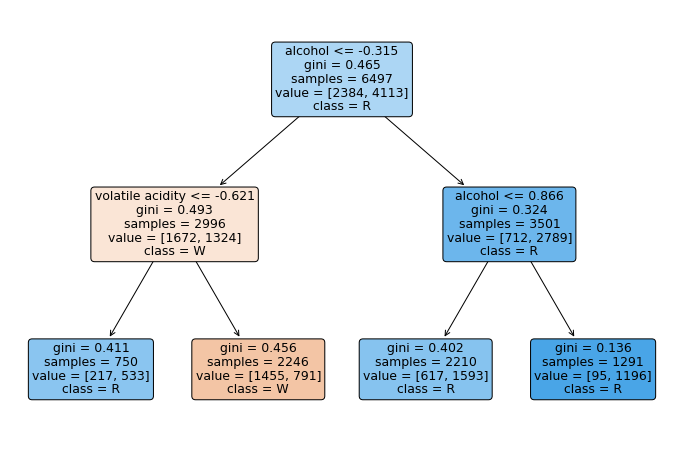

In [10]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(GridSearch.best_estimator_['clf'], feature_names=X.columns,
         class_names=['W', 'R'],
         rounded=True, filled=True);

In [11]:
dict(zip(X.columns, GridSearch.best_estimator_['clf'].feature_importances_))

{'fixed acidity': 0.0,
 'volatile acidity': 0.23321211154251176,
 'citric acid': 0.0,
 'residual sugar': 0.0,
 'chlorides': 0.0,
 'free sulfur dioxide': 0.0,
 'total sulfur dioxide': 0.0,
 'density': 0.0,
 'pH': 0.0,
 'sulphates': 0.0,
 'alcohol': 0.7667878884574882,
 'color': 0.0}

#### 표로 성능 결과를 정리하자

In [12]:
import pandas as pd

score_df = pd.DataFrame(GridSearch.cv_results_)
score_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]

,params,rank_test_score,mean_test_score,std_test_score
0,{'clf__max_depth': 2},1,0.688800,0.071799
1,{'clf__max_depth': 4},2,0.663565,0.083905
2,{'clf__max_depth': 7},3,0.653408,0.086993
3,{'clf__max_depth': 10},4,0.644016,0.076915


- accuracy의 평균과 표준편차를 보자